# **Analiza povezanosti između fizičke aktivnosti, kvalitete života i mentalnog zdravlja**

In [ ]:
!python -m pip install pandas

## Način prikupljanja podataka

Za odabranu temu koristia sam web stranicu generatedata.com (https://generatedata.com), kako bi generirala potrebne podatke za izvršavanje projekta. Na navedenoj stranici odabrala sam si sve potrebne atribute,  kao što su ime, prezime, spol, godine, država, adresa, e-mail i vrsta aktivnosti. Ostale podatke sam popunila nasumičnim vrijednostima. Dobivene podatke sam izvezla u obliku JSON i CSV formatu.



## Način pretprocesiranja
JSON podaci su učitani pomoću korištenja funkcije pd.read_json(), gdje su na taj način učitani podaci iz JSON datoteke u DataFrame. Uklonjeni su  stupci koji nisu bili potrebni za daljnju analizu, pomoću drop() funkcije. Stupci koj su uklonjeni bili su: 'drzava', 'adresa' i 'email'. Sa argumentom axis=1 inplace=True uklonili su se nepotrebni stupci. Na taj način napravljen je korak pretprocesuiranja u kojem se izvršilo čišćeje i preiprema podataka za jednostavniju analizu.

In [ ]:
import pandas as pd
json_path = "projekt_grseta.json"
json_data = pd.read_json(json_path)
json_data.drop(['email', 'adresa', 'drzava'], axis=1, inplace=True)
print(json_data.head())

   id          ime_prezime  godine spol  trajanje_aktivnosti_dnevno  tjedno
0   1       Leonarda Moret      28    F                          90       4
1   2         Sara Chepman      21    F                          81       6
2   3  Sebastian Rodriquez      33    M                         100       5
3   4             Ken Gers      43    M                          66       4
4   5     Carlo Mccullough      57    M                          50       3


## Integracija podataka iz više skupova
CSV datoteka je učitana pomoću pd_read(), a pd.merge() se koristio za spajanje podataka iz CSV I JSON datoteke. Navedena funkcija je omogućila spajanje dva DataFrame-a na temelju 'id'-a.

In [ ]:
csv_path = "projekt_grseta.csv"
csv_data = pd.read_csv(csv_path, encoding='latin-1')
# integracija podataka, spajamo podatke iz CSV i JSON datoteka po id-ju
combined_data = pd.merge(csv_data, json_data, on='id')
print(combined_data.head())

   id vrsta_aktivnosti  samoprocjena razina_stresa         kvaliteta_sna  \
0   1            ragbi             6         niska            vrlo dobra   
1   2         plivanje             9    bez stresa            vrlo dobra   
2   3          rukomet             5         niska  bolja nego uobicajno   
3   4             ples             3         niska                 dobra   
4   5     planinarenje             7    bez stresa  bolja nego uobicajno   

   opce_zadovoljstvo          dodatne_navike       socijalizacija  \
0                  4  setnja kucnog ljubimca  visa nego uobicajno   
1                  2        dodatni treninzi  visa nego uobicajno   
2                  7             hidratacija  visa nego uobicajno   
3                  9              meditacija  visa nego uobicajno   
4                  2               bolji san  visa nego uobicajno   

           ime_prezime  godine spol  trajanje_aktivnosti_dnevno  tjedno  
0       Leonarda Moret      28    F                   

## Način pohrane integriranog skupa podataka
Biblioteka koje su se za ispravan rad trebale uvesti su sqlite3 i pandas. Sqlite3 omogćava rad sa SQLite bazama te uz pomoć funkcije sqlite3.connect('projekt_grseta.db') kreirana je nova SQLite baza podataka nazvana 'projekt_grseta.db'. Jedan od uvjeta je bi da ako baza podataka s tim imenom već postoji, funkcija će uspostaviti vezu s postojećom bazom.
Koristeći metodu to_sql iz Pandas DataFrame-a, podaci iz DataFrame-a 'combined_data' pohranjeni su u SQLite bazu podataka. Tablica u bazi podataka u koju su podaci spremljeni nazvana je 'integrirani_skup_podataka'.
Na kraju, veza s bazom podataka zatvorena je pomoću conn.close()

In [ ]:
import sqlite3

# povezivanje s SQLite bazom podataka
conn = sqlite3.connect('baza_grseta.db')

# spremanje dataframe u bazu podataka
combined_data.to_sql('integrirani_skup_podataka', conn, if_exists='replace', index=False)
conn.close()

## Izrada sučelja
Za kreiranje web aplikacije, importirana je biblioteka Flask. Za pretvaranje Python rječnika u JSON odgovor koristio se jsonfy, a sqlite3 se koristio za interakciju s SQLite bazom podataka. Kako bi se omogućilo samo pokretanje aplikacije korišten je threading. Instanca Flask aplikacije kreirana je pomoću 'app = Flask(_name_)'. Funkcija get_db_connection osigurava povezivanje s SQLite bazom podataka baza_grseta.db. Također, postavlja format rezultata SQL upita kao rječnik (sqlite3.Row), što olakšava rukovanje podacima.

Endpoint za dohvaćanje svih podataka kreiran je na slijedeći način: @app.route('/integrirani_skup_podataka', methods=['GET']). Kada  klijent pošalje GET zahtjev na navedenu adresu, krene se izvršavati funkcija get_data. Na taj način funkcija se povezuje s bazom potaka te se izvršava SQL upit SELECT * FROM integrirani_skup_podataka za dohvaćanje svih zapisa iz tablice. Dobiveni rezultat upita se konvertira u listu rječnika, a zatim u JSON format. Nakon uspješnog izvođenjau zatvara se veza s bazom i vraćaju se podaci klijentu.

Endpoint @app.route('/integrirani_skup_podataka/<int:id>', methods=['GET']) omogućava dohvaćanje specifičnog zapisa temeljenog na danom ID-u.

Za neovisan rad aplikacije naspram ostatka koda, koristi se funkcija run_app koja pokreće Flask aplikaciju na portu 5000.

Kako bi se pokrenula Flask aplikacija, koristi se modul threading: flask_thread = threading.Thread(target=run_app)
flask_thread.start().





In [ ]:
!python -m pip install flask

In [ ]:
from flask import Flask, jsonify
import threading

app = Flask(__name__)

def get_db_connection():
    conn = sqlite3.connect('baza_grseta.db')
    conn.row_factory = sqlite3.Row
    return conn

@app.route('/integrirani_skup_podataka', methods=['GET'])
def get_data():
    conn = get_db_connection()
    cursor = conn.cursor()
    cursor.execute('SELECT * integrirani_skup_podataka')
    data = cursor.fetchall()
    conn.close()
    data_list = [dict(ix) for ix in data]
    return jsonify(data_list)

@app.route('/integrirani_skup_podataka/<int:id>', methods=['GET'])
def get_data_by_id(id):
    conn = get_db_connection()
    cursor = conn.cursor()
    cursor.execute('SELECT * FROM integrirani_skup_podataka WHERE id = ?', (id,))
    data = cursor.fetchone()
    conn.close()
    return jsonify(dict(data)) if data else 'Data not found', 404

# pokretanje Flask aplikacije u zasebnoj dretvi
def run_app():
    app.run(port=5000, use_reloader=False, debug=True)

flask_thread = threading.Thread(target=run_app)
flask_thread.start()

 * Serving Flask app '__main__'
 * Debug mode: on


## Bazična analiza podataka i vizualizacija
Podaci iz SQLite baze učitani su u Pandas DataFrame za samu analizu podataka. Napravljena je statistička analiza na način da je izvedena opisna statistika za numeričke stupce. Vizualizacija analize podataka napravljena je pomoću histograma za samo lakše razumijevanje dobivenih rezultata.

Vizualizacija:
1. Broj osoba po vrsti aktivnosti -> prikaz koliki broj osoba trenira određenu aktivnost.
2. Dobne skupine i učestalost treninga -> prikaz kako su godine osoba.raspoređene te koliko često treniraju
3. Razina stresa u odnosu na spol -> prikaz je raspoređen na dva spola te prikazuje koji spol doživljava višu ili nižu razinu stresa.
4. Učestalost treninga u odnosu na razinu stresa -> prikazuje koliko osobe često treniraju i kako ta učestalost treninga utječe na njihovu razinu stresa.
5. Učestalost treninga u odnosu na spol -> prikaz koji spoli više trenira, odnosto koliko često koji spol trenira dana u tjednu.
6. Kvaliteta sna u odnosu na trajanje aktivnosti -> prikaz omjera između broja osoba po određenoj aktivnosti naspram koliko dugo osoba trenira neku vrstu aktivnosti.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

db_path = 'baza_grseta.db'
conn = sqlite3.connect(db_path)
query = "SELECT * FROM integrirani_skup_podataka"

# učitavanje podataka u dataframe i prikaz nekoliko redova dataframe-a
data_df = pd.read_sql_query(query, conn)
conn.close()
data_df.head()

,id,vrsta_aktivnosti,samoprocjena,razina_stresa,kvaliteta_sna,opce_zadovoljstvo,dodatne_navike,socijalizacija,ime_prezime,godine,spol,trajanje_aktivnosti_dnevno,tjedno
0,1,ragbi,6,niska,vrlo dobra,4,setnja kucnog ljubimca,visa nego uobicajno,Leonarda Moret,28,F,90,4
1,2,plivanje,9,bez stresa,vrlo dobra,2,dodatni treninzi,visa nego uobicajno,Sara Chepman,21,F,81,6
2,3,rukomet,5,niska,bolja nego uobicajno,7,hidratacija,visa nego uobicajno,Sebastian Rodriquez,33,M,100,5
3,4,ples,3,niska,dobra,9,meditacija,visa nego uobicajno,Ken Gers,43,M,66,4
4,5,planinarenje,7,bez stresa,bolja nego uobicajno,2,bolji san,visa nego uobicajno,Carlo Mccullough,57,M,50,3


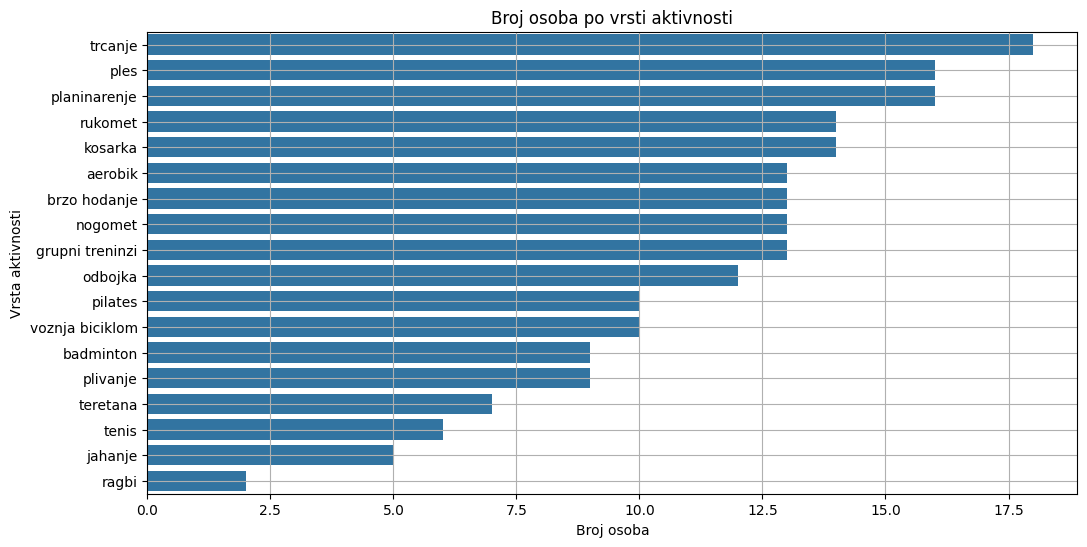

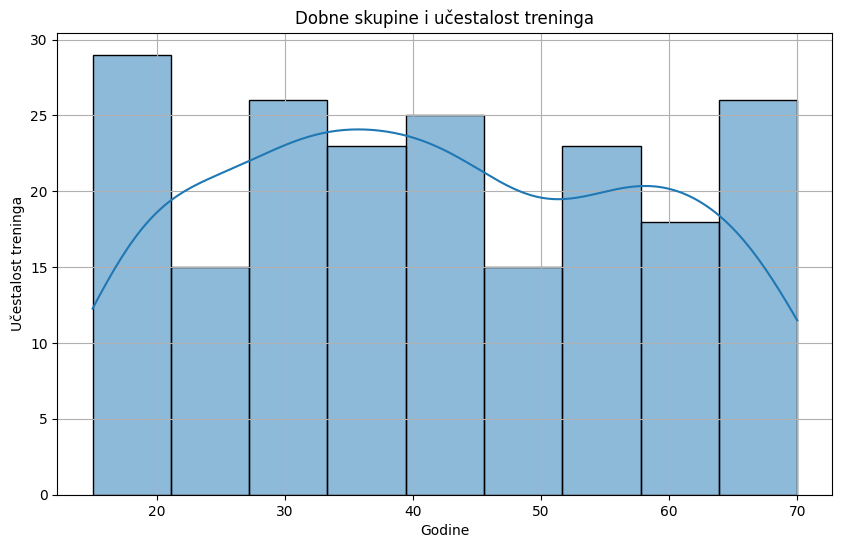

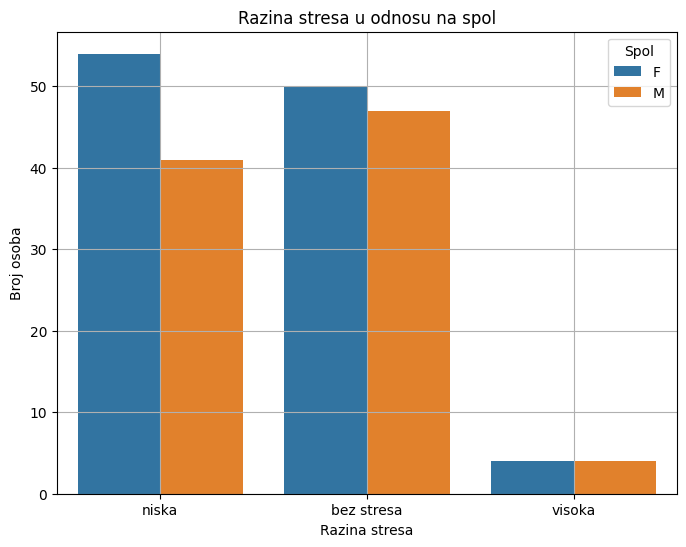

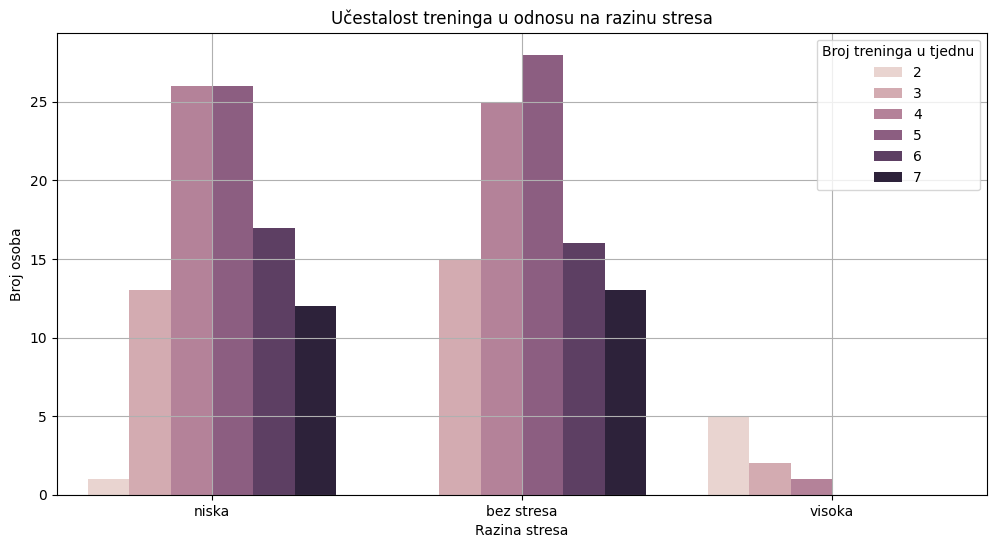

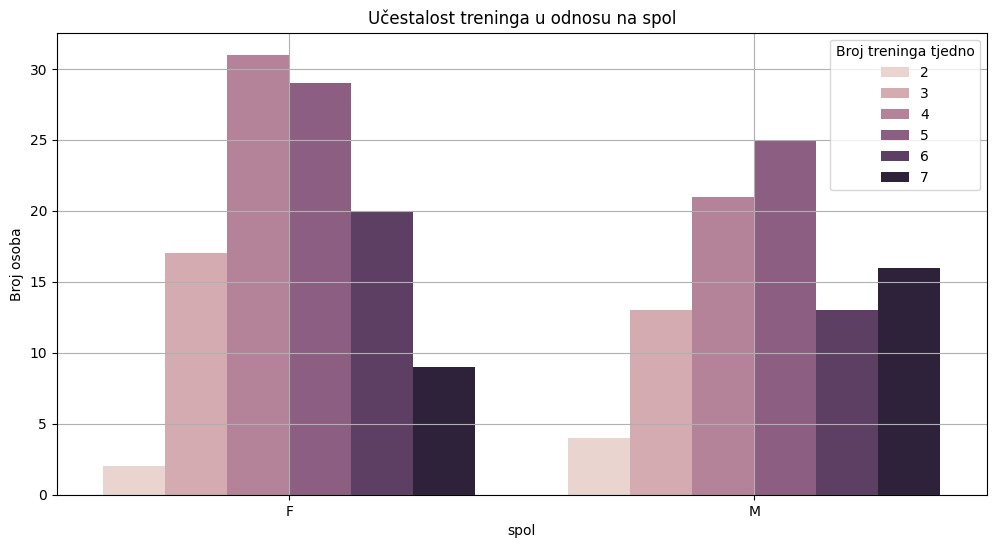

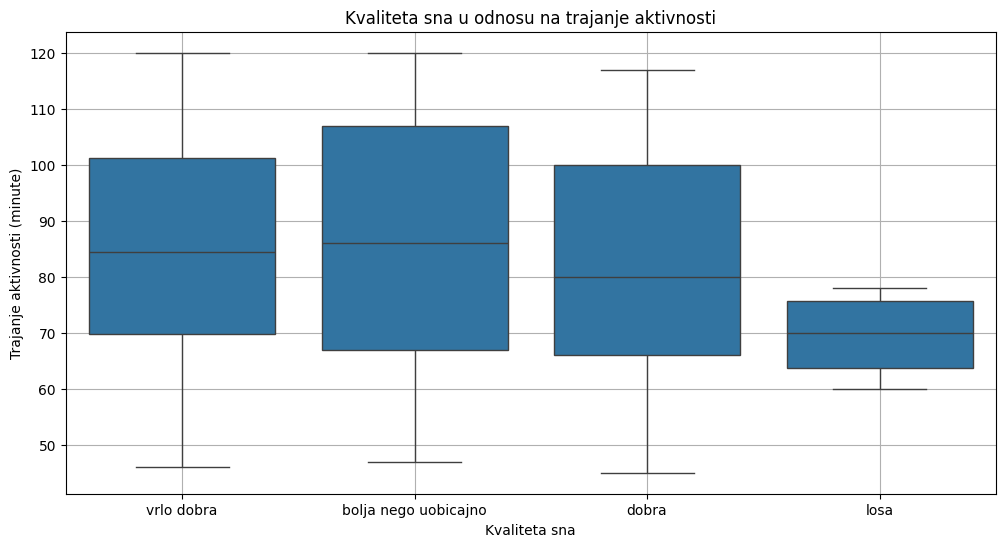

In [ ]:
# opisna statistika za numeričke stupce
descriptive_stats = data_df.describe()

# broj osoba po vrsti aktivnosti
plt.figure(figsize=(12, 6))
sns.countplot(y='vrsta_aktivnosti', data=data_df, order = data_df['vrsta_aktivnosti'].value_counts().index)
plt.title('Broj osoba po vrsti aktivnosti')
plt.xlabel('Broj osoba')
plt.ylabel('Vrsta aktivnosti')
plt.grid(True)
plt.show()

# dobne skupine i učestalost treninga
plt.figure(figsize=(10, 6))
sns.histplot(data_df['godine'], kde=True)
plt.title('Dobne skupine i učestalost treninga')
plt.xlabel('Godine')
plt.ylabel('Učestalost treninga')
plt.grid(True)
plt.show()

# spol i razina stresa
plt.figure(figsize=(8, 6))
sns.countplot(x='razina_stresa', hue='spol', data=data_df)
plt.title('Razina stresa u odnosu na spol')
plt.xlabel('Razina stresa')
plt.ylabel('Broj osoba')
plt.legend(title='Spol')
plt.grid(True)
plt.show()

# učestalost treninga u odnosu na razinu stresa
plt.figure(figsize=(12, 6))
sns.countplot(x='razina_stresa', data=data_df, hue='tjedno')
plt.title('Učestalost treninga u odnosu na razinu stresa')
plt.xlabel('Razina stresa')
plt.ylabel('Broj osoba')
plt.legend(title='Broj treninga u tjednu', loc='upper right')
plt.grid(True)
plt.show()

# spol i učestalost treninga
plt.figure(figsize=(12, 6))
sns.countplot(x='spol', hue='tjedno', data=data_df)
plt.title('Učestalost treninga u odnosu na spol')
plt.ylabel('Broj osoba')
plt.legend(title='Broj treninga tjedno')
plt.grid(True)
plt.show()

# kvaliteta sna u odnosu na trajanje aktivnosti po danu
plt.figure(figsize=(12, 6))
sns.boxplot(x='kvaliteta_sna', y='trajanje_aktivnosti_dnevno', data=data_df)
plt.title('Kvaliteta sna u odnosu na trajanje aktivnosti')
plt.xlabel('Kvaliteta sna')
plt.ylabel('Trajanje aktivnosti (minute)')
plt.grid(True)
plt.show()









## Uvod
Temu analiza povezanosti između fizičke aktivnosti, kvalitete života i mentalnog zdravlja odabrala sam iz razloga što sam se jako dugo bavila atletikom i plesom te su mi poznate prednosti bavljenja svakodnevne aktivnosti, ali isto tako i nedostaci prestanka bavljenja. Također sam ovu temu odabrala zato što za završni rad imam dosta sličnu temu pa mogu dio ovog projekta koristiti za završni rad. Prema [3] "Tjelesna aktivnost ima važnu ulogu u poboljšanju psihičkog zdravlja. Procesi kojima rekreacijska aktivnost utječe na opću dobrobit i mentalno zdravlje su veoma složeni. Zbog toga je jako teško odrediti element ponašanja i aktivnost koja će sa sigurnošću donijeti korist u bavljenju fizičkom aktivnosti". Te se sa navedeim dijelom slažem i smatram da pogotovu u današnje doba, gdje se tehnologija jako brzo razvija i kada sve piše vremena provodim za računalima, mobitelima te ostalim uređajima bitna aktivnost za naše mentalno i fizičko zdravlje. Za analizu ove teme sam koristila generirane podatke kako bi imala što više podataka, a i na taj način olakšala zapravo pronalazak podataka. Dobiveni rezultati nisu relavantni pa bi se za točnu analizu trebala provesti anketa između veće skupine osoba.
## Implementacija

Implementacija obuhvaća prikupljanje podataka, njihovo pretprocesiranje i integraciju, pohranu podataka, razvoj sučelja za pristup podacima, osnovnu analizu te vizualizaciju podataka. Podaci su prikupljeni pomoću online alata *generatedata.com*, pri čemu su generirane dvije datoteke: JSON i CSV. JSON datoteka sadrži informacije poput imena, adrese, godine, spol i trajanja fizičke aktivnosti, dok CSV datoteka uključuje dodatne podatke o samoprocjeni, razini stresa, kvaliteti sna i ostalim životnim aspektima.

Pretprocesiranje je uključivalo učitavanje i obradu podataka iz obje vrste datoteka. Kako bi se pojednostavila analiza, iz JSON datoteke uklonjeni su nepotrebni atributi poput e-maila, adrese i države za svih  sudionika istraživanja. Nakon toga, podaci iz JSON i CSV datoteka integrirani su pomoću jedinstvenog identifikatora 'id', čime je stvoren objedinjeni skup podataka za daljnju obradu. Kombinirani podaci pohranjeni su u SQLite bazu podataka pod nazivom "bazat_grseta.db" te time omogućujući trajnu pohranu i pristup putem SQL upita.

Sučelje za pristup podacima implementirano je kao RESTful API koristeći Flask, Python web framework. API omogućuje dohvaćanje, filtriranje i manipulaciju podacima iz baze. Definirani su endpoints za dohvat svih podataka, podataka o pojedinim sudionicima te za izvoz podataka u različitim formatima. Analiza podataka provedena je uz pomoć biblioteka poput pandas, matplotlib i seaborn. Osnovna analiza uključivala je statističke izračune, pregled distribucije vrijednosti i utvrđivanje korelacija između varijabli. Vizualizacija rezultata realizirana je kroz grafove i histograme što omogućuje lakše razumijevanje i interpretaciju rezultata analize.
## Prikaz rada aplikacije
 Napravljena aplikacije temelji se na korištenju Flask-a za razvoj web aplikacije i integraciju sa SQLite bazom podataka za pohranu, pristup i obradu podataka. Funkcionalnosti sučelja uključuju prikaz podataka u tablicama, vizualizaciju podataka putem različitih grafičkih prikaza. Kao što su stupčasti dijagram te mogućnost izvođenja osnovnih statističkih analiza.
## Kritički osvrt

Projekt je realiziran uz pomoć Python biblioteka Pandas i SQLite za obradu i analizu podataka, a za vizualizaciju korišten je  Matplotlib i Seaborn. Glavni izvor podataka u ovom projektu čine informacije o stanjima pojedinaca i njihovim tjednim, odnosno dnevnim navikama. Prva faza obrade podataka uključivala je provjeru potpunosti podataka u datasetovima, pri čemu je utvrđeno da nema nedostajućih vrijednosti. Nakon ove provjere, podaci su objedinjeni u novi DataFrame. Analiza podataka započela je statističkim ispitivanjem trajanja aktivnosti kao jednog od ključnih atributa. Grafički prikazi prikazali su dvije glavne raspodjele podataka. U prvoj su se prikazali odnosi na trajanje aktivnosti u korelaciji s pozitivnim navikama pojedinaca, dok druga prikazuje raspodjelu općeg zadovoljstva pojedinaca.
Kao što je već spomenuto više puta, podaci nisu stvarni. Iako podaci nisu stvari, smatram da se neko ovako istraživanje može provesti u stvarnosti te bi se na taj način pokazala stvarnost utjecaja fizičke aktivnosti na kvalitetu života i mentalno zdravlje.

## Zaključak

Projekt istražuje povezanost fizičke aktivnosti, kvalitete života i mentalnog zdravlja, oslanjajući se na generirane podatke kao temelj za analizu. Iako podaci nisu stvarni, omogućili su izradu funkcionalne aplikacije koja demonstrira proces prikupljanja, obrade i analize podataka, te pruža uvid u potencijalne obrasce povezanosti između analiziranih varijabli. Implementacija je pokazala tehničke aspekte izrade sustava, uključujući korištenje alata poput Flask-a, SQLite-a i Python biblioteka Pandas, Matplotlib i Seaborn.

Dobiveni rezultati sugeriraju da fizička aktivnost može biti značajan faktor za kvalitetu života i mentalno zdravlje, no njihova potpuna validacija zahtijevala bi provođenje stvarnog istraživanja s većom i reprezentativnijom skupinom sudionika. Ovo istraživanje pruža temelj za budući rad, u kojem bi se stvarni podaci mogli koristiti za precizniju analizu utjecaja fizičke aktivnosti na život pojedinaca. Kroz ovaj projekt istaknuta je važnost svakodnevne tjelesne aktivnosti, posebno u današnjem vremenu ubrzanog razvoja tehnologije i sve češćeg sjedilačkog načina života.

## Literatura
1. DataGenerator (https://generatedata.com/)
2. ChatGPT (https://chat.openai.com/)
3.  UTJECAJ REKREACIJSKIH AKTIVNOSTI NA MENTALNO ZDRAVLJE, Ilija Marić, Franjo Lovrić, Darjan Franjić(https://hrcak.srce.hr/file/364944); pristupljeno 24.01.2025.